# 2D CNN with Laplace Beltrami Spectrum

## Binary Classification: Males vs. Females

Here we are going to see if we can create a 2 dimensional convolutional neural network that can classify a subject as male or female based on the shape (LB spectrum) of their white matter tracts.

The initial set up will be very similar to the MLP and 1D CNN, but the final shape of the data will be different. The network architecture will be similar to the 2D CNN, but they will be 2D convolutional layers instead of 1D. 


### Import libraries
First, let's import the libraries we will use.

In [1]:
#to read in the data
import pickle
#for plotting, numbers etc.
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#for splitting the data
from sklearn.model_selection import train_test_split
#keras functions
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, GlobalAveragePooling2D, MaxPooling2D
from keras.utils import np_utils, plot_model, to_categorical
from keras.optimizers import Adam, RMSprop

#normalize the data
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegressionCV 

/home/pestillilab/anaconda2/envs/tf1.4py2.7/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Import and check the data
Now let's read in the data using pickle. The data was previously processed in python and saved down using pickle. This will be the same steps as used in the MLP notebook so I will not include as many comments

In [2]:
# eigenvalue dictionary with entry for eact tract, 600 evs per tract
tractev_dict_600 = pickle.load(open("tract_ev_dict_600.pk",'rb'))
# list of tracts we want to use
tractstouse = pickle.load(open('tractstouse.pk','rb'))
# subject list
HCP_subj_list = pickle.load(open('HCP_subj_list.pk','rb'))
# list of subject gender 1 = male, 2 = female
gender_id = pickle.load(open('gender_id.pk','rb'))

### Preprocess the data
The eigenvalue data is already in a vector format, so we do not need to vectorize it. However, we will need to combine the vectors of all the tracts so that we have a 2D matrix per subject. We will have one row per tract and one column per eigenvalue.

We also need to normalize the data so that each set of eigenvalues has a mean of 0 and a standard deviation of 1. We will write a function to do this using sklearn's StandardScaler function.

**Normalize the data**

In [3]:
def scale_ev_dict(ev_dict):
    scaled_dict = {}
    for tract in ev_dict.keys():
        scaler = StandardScaler()
        scaled_dict[tract] = scaler.fit_transform(ev_dict[tract])
    return scaled_dict


In [4]:
# normalize all of the tracts so that each ev is centered on 0.
tractev_dict_600_scaled = scale_ev_dict(tractev_dict_600)

### Reorganize the data

Currently the data is a dictionary of 2D matrices, we want to reorganize this into an array of 2D matrices with the shape (num subjects, num tracts, num eigenvalues, 1).

It is likely that 600 eigenvalues is way more than we need, but we do not know how many eigenvalues is optimal. We will write a function to do this reorganization so we can easily try multiple amounts of eigenvalues if necessary.

In [5]:
#numeber of evs to use per tract. We will keep it the same for all.
numev = 200

# change the organization to be an array with one row per tract and one row per ev, per subj.

allsubjs_alltracts_array = np.zeros([len(HCP_subj_list), len(tractstouse), numev])
for i in range(len(tractstouse)):
    allsubjs_alltracts_array[:, i, :] = tractev_dict_600_scaled[tractstouse[i]][:, 0:numev]


In [9]:
allsubjs_alltracts_array.shape

(1013, 48, 200, 1)

In [10]:
allsubjs_alltracts_array = allsubjs_alltracts_array.reshape(allsubjs_alltracts_array.shape[0],allsubjs_alltracts_array.shape[1], allsubjs_alltracts_array.shape[2], 1)

allsubjs_alltracts_array = allsubjs_alltracts_array.astype('float32')


In [11]:
allsubjs_alltracts_array.shape

(1013, 48, 200, 1)

**one hot encode the labels**

In [12]:
# one-hot encoding for the gender ID
genderid_ohe = np.asarray(gender_id) - 1
genderid_ohe = genderid_ohe.astype('float32')

### Split the data
The input data is now preprocessed and ready to be input into a neural network. However, we first have to split the data into training, validation, and testing sets. We do not have a ton of samples, so we will try splitting the data into 3 subsets first and then explore other cross validation options if necessary.




In [13]:
X = allsubjs_alltracts_array
Y = genderid_ohe

#first split the training/validation data from the testing data
trainvalX, testX, trainvalY, testY = train_test_split(X, Y, train_size  = .8, test_size = .2, random_state=0)

print len(trainvalX) 
print len(testX)

810
203


In [14]:
#second split the validation data from the training data
trainX, valX, trainY, valY = train_test_split(trainvalX, trainvalY, train_size  = .75, test_size = .25, random_state=0)

print len(trainX)
print len(valX)

607
203


Now we have 3 subsets of data. Training data with 607 samples, validation data with 203 samples, and testing data with 203 samples. Again, this may be too few samples for training and if so we can employ other cross validation methods.

Let's first define our function for plotting the training history.

In [15]:
def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(network_history.history['loss'])
    plt.plot(network_history.history['val_loss'])
    plt.legend(['Training','Validation'])
    
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Acc')
    plt.plot(network_history.history['acc'])
    plt.plot(network_history.history['val_acc'])
    plt.legend(['Training','Validation'])
    plt.show()

In [16]:
from keras import backend as K
import gc

In [17]:
#sometimes python does not release memory very well on its own, these help clear memory
K.clear_session()
gc.collect()

12

Let's try a model architecture similar to the one we used with the 1D CNN but let's add a MaxPooling layer at the end to reduce some of the dimensionality before the final dense layer.

Train on 607 samples, validate on 203 samples
Epoch 1/60
607/607 [==============================] - 3s 5ms/step - loss: 0.7090 - acc: 0.4679 - val_loss: 0.6916 - val_acc: 0.5567
Epoch 2/60
607/607 [==============================] - 1s 2ms/step - loss: 0.6855 - acc: 0.5519 - val_loss: 0.6874 - val_acc: 0.5764
Epoch 3/60
607/607 [==============================] - 1s 2ms/step - loss: 0.6799 - acc: 0.5684 - val_loss: 0.6829 - val_acc: 0.5862
Epoch 4/60
607/607 [==============================] - 1s 2ms/step - loss: 0.6742 - acc: 0.5997 - val_loss: 0.6762 - val_acc: 0.6256
Epoch 5/60
607/607 [==============================] - 1s 2ms/step - loss: 0.6673 - acc: 0.5964 - val_loss: 0.6677 - val_acc: 0.6453
Epoch 6/60
607/607 [==============================] - 1s 2ms/step - loss: 0.6567 - acc: 0.6491 - val_loss: 0.6576 - val_acc: 0.6601
Epoch 7/60
607/607 [==============================] - 1s 2ms/step - loss: 0.6465 - acc: 0.6557 - val_loss: 0.6436 - val_acc: 0.6897
Epoch 8/60
607/607 [==========

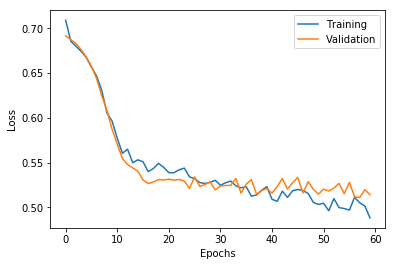

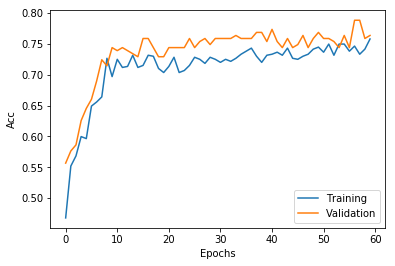

In [15]:
adam = Adam(lr=.00001)

model = Sequential()
model.add(Conv2D(64, kernel_size=(3), activation='relu', input_shape=(allsubjs_alltracts_array.shape[1],allsubjs_alltracts_array.shape[2],1)))
model.add(Conv2D(64, kernel_size=(3), activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.5))
model.add(Conv2D(64, kernel_size=(3), activation='relu'))
model.add(Conv2D(64, kernel_size=(3), activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
# model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
#model.add(Activation('softmax'))

model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(trainX, trainY, epochs=60, batch_size=10, validation_data=(valX, valY))


plot_history(history)


The highest validation accuracy was 79%. This is a good start. Let's add in regularization and change some of the parameters.

In [18]:
from keras.regularizers import l1, l2, l1_l2

Train on 607 samples, validate on 203 samples
Epoch 1/20
607/607 [==============================] - 4s 6ms/step - loss: 0.8173 - acc: 0.5502 - val_loss: 0.7481 - val_acc: 0.7685
Epoch 2/20
607/607 [==============================] - 2s 3ms/step - loss: 0.7064 - acc: 0.6656 - val_loss: 0.6599 - val_acc: 0.7340
Epoch 3/20
607/607 [==============================] - 2s 3ms/step - loss: 0.6568 - acc: 0.6952 - val_loss: 0.6439 - val_acc: 0.7635
Epoch 4/20
607/607 [==============================] - 2s 3ms/step - loss: 0.6451 - acc: 0.7051 - val_loss: 0.6294 - val_acc: 0.7635
Epoch 5/20
607/607 [==============================] - 2s 3ms/step - loss: 0.6252 - acc: 0.7166 - val_loss: 0.6204 - val_acc: 0.7734
Epoch 6/20
607/607 [==============================] - 2s 3ms/step - loss: 0.6379 - acc: 0.7018 - val_loss: 0.6258 - val_acc: 0.7833
Epoch 7/20
607/607 [==============================] - 2s 3ms/step - loss: 0.6179 - acc: 0.7068 - val_loss: 0.6059 - val_acc: 0.7685
Epoch 8/20
607/607 [==========

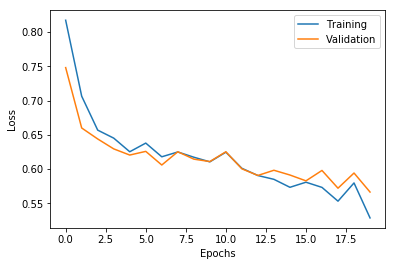

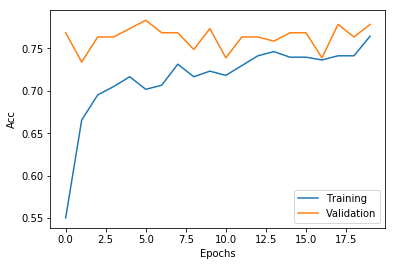

In [36]:
adam = Adam(lr=.0001)

model = Sequential()
model.add(Conv2D(100, kernel_size=(3), activation='relu', input_shape=(allsubjs_alltracts_array.shape[1],
                                                                       allsubjs_alltracts_array.shape[2],1),
                                                                         kernel_regularizer=l2(.0001)))
model.add(Conv2D(100, kernel_size=(3), activation='relu', kernel_regularizer=l2(.0001)))
model.add(MaxPooling2D())
model.add(Dropout(0.7))
model.add(Conv2D(100, kernel_size=(3), activation='relu', kernel_regularizer=l2(.0001)))
model.add(Conv2D(100, kernel_size=(3), activation='relu', kernel_regularizer=l2(.0001)))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(300, activation='relu', kernel_regularizer=l2(.0001)))
model.add(Dropout(0.7))
model.add(Dense(1, activation='sigmoid'))
#model.add(Activation('softmax'))

model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(trainX, trainY, epochs=20, batch_size=20, validation_data=(valX, valY))


plot_history(history)

The highest validation accuracy was 78%, so this did not help much. Let's try removing that final MaxPooling layer. 

Train on 607 samples, validate on 203 samples
Epoch 1/20
607/607 [==============================] - 3s 6ms/step - loss: 1.3254 - acc: 0.6129 - val_loss: 1.2269 - val_acc: 0.7635
Epoch 2/20
607/607 [==============================] - 1s 2ms/step - loss: 1.2068 - acc: 0.7348 - val_loss: 1.1371 - val_acc: 0.7734
Epoch 3/20
607/607 [==============================] - 1s 2ms/step - loss: 1.2036 - acc: 0.7282 - val_loss: 1.1749 - val_acc: 0.7094
Epoch 4/20
607/607 [==============================] - 1s 2ms/step - loss: 1.1495 - acc: 0.7430 - val_loss: 1.1009 - val_acc: 0.8030
Epoch 5/20
607/607 [==============================] - 1s 2ms/step - loss: 1.1057 - acc: 0.7727 - val_loss: 1.0859 - val_acc: 0.7980
Epoch 6/20
607/607 [==============================] - 1s 2ms/step - loss: 1.0850 - acc: 0.7908 - val_loss: 1.0710 - val_acc: 0.7882
Epoch 7/20
607/607 [==============================] - 1s 2ms/step - loss: 1.0445 - acc: 0.8105 - val_loss: 1.0541 - val_acc: 0.8079
Epoch 8/20
607/607 [==========

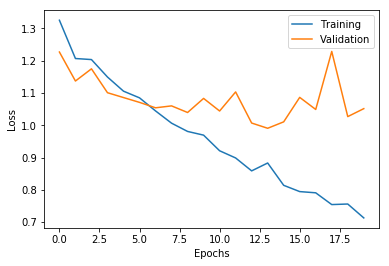

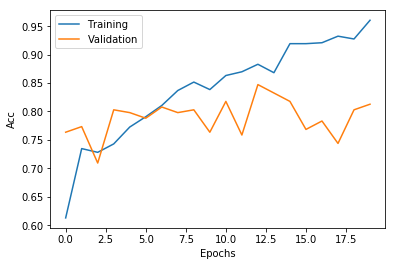

In [43]:
adam = Adam(lr=.0001)

model = Sequential()
model.add(Conv2D(80, kernel_size=(3), activation='relu', input_shape=(allsubjs_alltracts_array.shape[1],
                                                                       allsubjs_alltracts_array.shape[2],1),
                                                                         kernel_regularizer=l1(.0001)))
model.add(Conv2D(80, kernel_size=(3), activation='relu', kernel_regularizer=l1(.0001)))
model.add(MaxPooling2D())
model.add(Dropout(0.5))
model.add(Conv2D(100, kernel_size=(3), activation='relu', kernel_regularizer=l1(.0001)))
model.add(Conv2D(100, kernel_size=(3), activation='relu', kernel_regularizer=l1(.0001)))
# model.add(MaxPooling2D())
model.add(Flatten())
# model.add(Dense(300, activation='relu', kernel_regularizer=l2(.0001)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
#model.add(Activation('softmax'))

model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(trainX, trainY, epochs=20, batch_size=20, validation_data=(valX, valY))


plot_history(history)

Removing the final MaxPooling increased the accuracy, but it quickly became overfit. We were able to reach a validation classification accuracy of 84%.

A next step would be to try a parameter search, such as a grid search, to find the best combination of hyperparamters. The grid search for the 1D CNN ran for over a week, so we will not run one here. Please view the notebook for the 1D CNN examples for an example of how to set up a grid search. 

Additionally, we saw with the 1D CNN that the grid search did not improve the accuracy we achieved with a manual parameter search and that a CNN did not do very well with this data.  84% validation accuracy is pretty good, so let's test the model above with the final testing data. 

First lets import the call back function so we can test on the best model

In [35]:
from keras.callbacks import ModelCheckpoint

Train on 810 samples, validate on 203 samples
Epoch 1/20
810/810 [==============================] - 4s 5ms/step - loss: 1.3099 - acc: 0.6025 - val_loss: 1.1980 - val_acc: 0.7241
Epoch 2/20
810/810 [==============================] - 2s 2ms/step - loss: 1.2169 - acc: 0.7086 - val_loss: 1.1690 - val_acc: 0.7291
Epoch 3/20
810/810 [==============================] - 2s 2ms/step - loss: 1.1571 - acc: 0.7395 - val_loss: 1.1479 - val_acc: 0.7291
Epoch 4/20
810/810 [==============================] - 2s 2ms/step - loss: 1.1160 - acc: 0.7642 - val_loss: 1.1214 - val_acc: 0.7586
Epoch 5/20
810/810 [==============================] - 2s 2ms/step - loss: 1.0659 - acc: 0.7926 - val_loss: 1.1281 - val_acc: 0.7685
Epoch 6/20
810/810 [==============================] - 2s 2ms/step - loss: 1.0179 - acc: 0.8198 - val_loss: 1.1343 - val_acc: 0.7635
Epoch 7/20
810/810 [==============================] - 2s 2ms/step - loss: 1.0018 - acc: 0.8296 - val_loss: 1.1174 - val_acc: 0.7635
Epoch 8/20
810/810 [==========

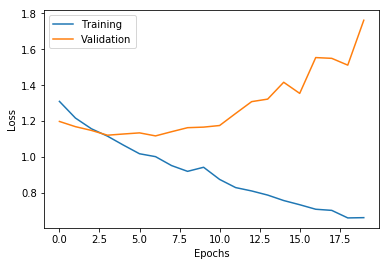

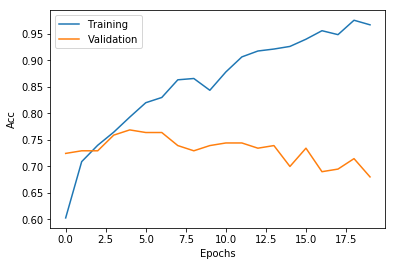

In [36]:
best_model = ModelCheckpoint('/home/pestillilab/lindsey/DeepLearningTutorial_LBspectrum/bestmodel_2dcnn_1.h5', monitor='val_acc', save_best_only=True)
adam = Adam(lr=.0001)

model = Sequential()
model.add(Conv2D(80, kernel_size=(3), activation='relu', input_shape=(allsubjs_alltracts_array.shape[1],
                                                                       allsubjs_alltracts_array.shape[2],1),
                                                                         kernel_regularizer=l1(.0001)))
model.add(Conv2D(80, kernel_size=(3), activation='relu', kernel_regularizer=l1(.0001)))
model.add(MaxPooling2D())
model.add(Dropout(0.5))
model.add(Conv2D(100, kernel_size=(3), activation='relu', kernel_regularizer=l1(.0001)))
model.add(Conv2D(100, kernel_size=(3), activation='relu', kernel_regularizer=l1(.0001)))
# model.add(MaxPooling2D())
model.add(Flatten())
# model.add(Dense(300, activation='relu', kernel_regularizer=l2(.0001)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
#model.add(Activation('softmax'))

model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(trainvalX, trainvalY, epochs=20, batch_size=20, validation_data=(testX, testY), callbacks=[best_model])


plot_history(history)

In [37]:
# final model of training
score = model.evaluate(testX, testY)
print score

203/203 [==============================] - 0s 704us/step
[1.7622776935840476, 0.679802956399072]


In [38]:
# load in the best model we saved down during training using the callback function
from keras.models import load_model
best_model1 = load_model('bestmodel_2dcnn_1.h5')

In [39]:
score = best_model1.evaluate(testX, testY)
print score

203/203 [==============================] - 0s 2ms/step
[1.1280632066021998, 0.7684729072847977]


The best model only reached ~77% accuracy, this is not very good, probably due to the overfitting of the model towards the training set of data. We can see in the plots that it becomes overfit almost immediately.

Let's go back to the network with a second MaxPooling layer and try a few more parameter adjustments. This network did not reach an accuracy higher than the logisitic regression classifier, but it also did not overfit.

Train on 607 samples, validate on 203 samples
Epoch 1/40
607/607 [==============================] - 3s 5ms/step - loss: 0.6919 - acc: 0.5041 - val_loss: 0.6879 - val_acc: 0.5025
Epoch 2/40
607/607 [==============================] - 1s 2ms/step - loss: 0.6800 - acc: 0.5601 - val_loss: 0.6792 - val_acc: 0.5172
Epoch 3/40
607/607 [==============================] - 1s 2ms/step - loss: 0.6655 - acc: 0.5848 - val_loss: 0.6658 - val_acc: 0.5714
Epoch 4/40
607/607 [==============================] - 1s 2ms/step - loss: 0.6520 - acc: 0.6376 - val_loss: 0.6422 - val_acc: 0.6847
Epoch 5/40
607/607 [==============================] - 1s 2ms/step - loss: 0.6238 - acc: 0.6853 - val_loss: 0.6128 - val_acc: 0.7340
Epoch 6/40
607/607 [==============================] - 1s 2ms/step - loss: 0.5974 - acc: 0.7068 - val_loss: 0.5818 - val_acc: 0.7291
Epoch 7/40
607/607 [==============================] - 1s 2ms/step - loss: 0.5753 - acc: 0.7002 - val_loss: 0.5544 - val_acc: 0.7537
Epoch 8/40
607/607 [==========

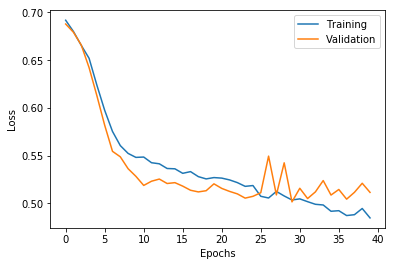

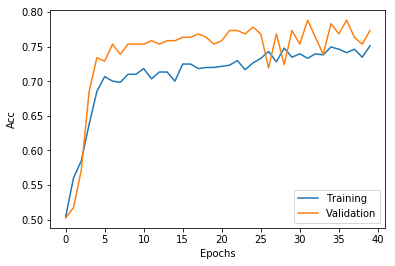

In [62]:
adam = Adam(lr=.00001)

model = Sequential()
model.add(Conv2D(64, kernel_size=(3), activation='relu', input_shape=(allsubjs_alltracts_array.shape[1],allsubjs_alltracts_array.shape[2],1)))
model.add(Conv2D(64, kernel_size=(3), activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.2))
model.add(Conv2D(64, kernel_size=(3), activation='relu'))
model.add(Conv2D(64, kernel_size=(3), activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
# model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
#model.add(Activation('softmax'))

model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(trainX, trainY, epochs=40, batch_size=10, validation_data=(valX, valY))


plot_history(history)


Ok, lets try the model above with the final testing data

Train on 810 samples, validate on 203 samples
Epoch 1/40
810/810 [==============================] - 4s 5ms/step - loss: 0.6880 - acc: 0.5346 - val_loss: 0.6807 - val_acc: 0.5320
Epoch 2/40
810/810 [==============================] - 2s 2ms/step - loss: 0.6680 - acc: 0.6086 - val_loss: 0.6594 - val_acc: 0.6404
Epoch 3/40
810/810 [==============================] - 2s 2ms/step - loss: 0.6396 - acc: 0.6704 - val_loss: 0.6259 - val_acc: 0.7044
Epoch 4/40
810/810 [==============================] - 2s 2ms/step - loss: 0.6050 - acc: 0.7099 - val_loss: 0.5934 - val_acc: 0.6749
Epoch 5/40
810/810 [==============================] - 2s 2ms/step - loss: 0.5722 - acc: 0.7160 - val_loss: 0.5632 - val_acc: 0.7241
Epoch 6/40
810/810 [==============================] - 2s 2ms/step - loss: 0.5538 - acc: 0.7123 - val_loss: 0.5470 - val_acc: 0.7192
Epoch 7/40
810/810 [==============================] - 2s 2ms/step - loss: 0.5451 - acc: 0.7111 - val_loss: 0.5393 - val_acc: 0.7241
Epoch 8/40
810/810 [==========

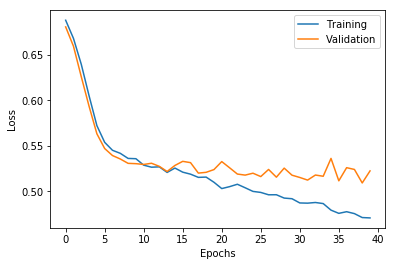

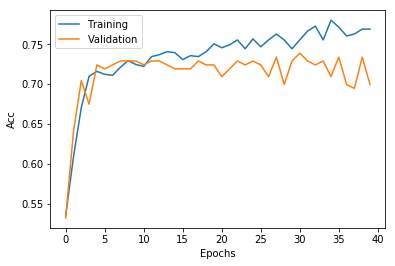

In [63]:
best_model = ModelCheckpoint('/home/pestillilab/lindsey/DeepLearningTutorial_LBspectrum/bestmodel_2dcnn_2.h5', monitor='val_acc', save_best_only=True)

adam = Adam(lr=.00001)

model = Sequential()
model.add(Conv2D(64, kernel_size=(3), activation='relu', input_shape=(allsubjs_alltracts_array.shape[1],allsubjs_alltracts_array.shape[2],1)))
model.add(Conv2D(64, kernel_size=(3), activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.2))
model.add(Conv2D(64, kernel_size=(3), activation='relu'))
model.add(Conv2D(64, kernel_size=(3), activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
# model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
#model.add(Activation('softmax'))

model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(trainvalX, trainvalY, epochs=40, batch_size=10, validation_data=(testX, testY), callbacks=[best_model])


plot_history(history)


In [64]:
# final model of training
score = model.evaluate(testX, testY)
print score

203/203 [==============================] - 0s 2ms/step
[0.5224638381615061, 0.6995073885753237]


In [65]:
# load in the best model we saved down during training using the callback function
from keras.models import load_model
best_model1 = load_model('bestmodel_2dcnn_2.h5')

In [66]:
score = best_model1.evaluate(testX, testY)
print score

203/203 [==============================] - 1s 4ms/step
[0.5152430977727392, 0.7389162555703976]


The best accuracy we got with this model is ~74%, worse that the model above and worse than the logistic regression classifier. 

## Final Comments

The goal was to build a 2D CNN that could classify individuals as male or female based on the shape of their white matter tracts (via the LB spectrum).

I met this goal and built multiple @D CNN neural networks that had higher than chance accuracy.

The secondary goal was to improve upon (if possible) the classification accuracy of a basic 'non-deep' machine learning algorithm and (if possible) the MLP and/or the 1D CNN.

This goal was not met. The final 'best' models achieved 77% and 74% classification accuracy with the testing data. This was not higher than the classification accuracy of the logistic regression classifier, the best MLP, or the 1D CNN.

As discussed with the 1D CNN, it may be that a CNN is not useful for this type of data. It also makes sense that the 2D CNN would perform worse than the 1D. The LB spectrum data is not 2D, the spatial relationships between the values of the rows (tracts) of the data probably do not provide any useful patterns as the order of the rows is set arbitrarily.

Of course it is still possible that I have not yet found the best parameters to use with the 2D CNN, especially because no parameter search was run. Further testing of parameter combinations should be done.

Additionally, as with the MLP and 1D CNN, I only used one set amount of eigenavalues (200) and one set of white matter tracts. Improvements could be made by testing different amounts of eigenvalues and different combinations of tracts.

### Please continue on to [Multi-Class Classification](https://github.com/kitchell/DeepLearningTutorial_LBspectrum/blob/master/Multi-Class%20Classification.ipynb)